In [1]:
# https://bigquery.cloud.google.com/dataset/the-psf:pypi

%matplotlib inline

import os
import io
import json
import functools

import pandas as pd
import pandas_gbq  # pip install "pandas-gbq>=0.2"

CRED_KW = {'token', 'refresh_token', 'id_token', 'token_uri', 'client_id', 'client_secret'}

PROJECT_ID = 'scripting-148608'

def load_credentials(filename, scopes):
    from google.oauth2.credentials import Credentials
    if os.path.exists(filename):
        with io.open(filename, 'rb') as f:
            kwargs = json.load(f)
        kwargs['token'] = kwargs.pop('access_token')
        kwargs = {k: v for k, v in kwargs.items() if k in CRED_KW}
        return Credentials(**kwargs, scopes=scopes)

def save_credentials(creds, filename):
    doc = {k: getattr(creds, k) for k in (CRED_KW - {'token'})}
    doc['access_token'] = creds.token
    with io.open(filename, 'wb') as f:
        json.dump(doc)
    
def get_credentials(scopes, secrets='~/client_secrets.json', storage='~/storage.json'):
    creds = load_credentials(os.path.expanduser(storage), scopes)
    if creds is None:
        from google_auth_oauthlib.flow import InstalledAppFlow
        flow = InstalledAppFlow.from_client_secrets_file(os.path.expanduser(secrets), scopes)
        flow.run_local_server()
        creds = flow.credentials
        save_credentials(creds, os.path.expanduser(storage))
    return creds

class GbqConnector(pandas_gbq.gbq.GbqConnector):

    def get_user_account_credentials(self):
        return get_credentials(self.scope)

pandas_gbq.gbq.GbqConnector = GbqConnector  # monkey patch

read_gbq = functools.partial(pd.io.gbq.read_gbq, dialect='standard', project_id=PROJECT_ID)

In [2]:
RESULT, START, END = 'pypi.csv', '20160601', '20170731'

PROJECTS = (
    'graphviz', 'features', 'concepts', 'bitsets', 'fileconfig',
    'gsheets', 'latexpages', 'dmengine', 'current',
)

QUERY ='''SELECT
  EXTRACT(YEAR FROM timestamp) AS year, EXTRACT(MONTH FROM timestamp) AS month,
  file.project AS project, file.version AS version, file.type AS type,
  country_code AS country,
  REGEXP_EXTRACT(details.python, r'^([^\.]+\.[^\.]+)') AS python,
  details.system.name AS system,
  COUNT(*) AS downloads
FROM `the-psf.pypi.downloads*`
WHERE _TABLE_SUFFIX BETWEEN '%s' AND '%s' AND file.project IN %r
GROUP BY year, month, project, version, type, country, python, system''' % (START, END, PROJECTS)

if not os.path.exists(RESULT):
    _df = read_gbq(QUERY)
    _df.to_csv(RESULT, index=False, encoding='utf-8')

INDEX = ['year', 'month', 'project', 'version', 'type', 'country', 'python', 'system']
ASC = [i not in ('year', 'month') for i in INDEX]
    
_df = pd.read_csv(RESULT, encoding='utf-8')\
    .sort_values(by=INDEX, ascending=ASC).reset_index(drop=True)
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74906 entries, 0 to 74905
Data columns (total 9 columns):
year         74906 non-null int64
month        74906 non-null int64
project      74906 non-null object
version      74906 non-null object
type         74906 non-null object
country      71123 non-null object
python       24552 non-null float64
system       21858 non-null object
downloads    74906 non-null int64
dtypes: float64(1), int64(3), object(5)
memory usage: 5.1+ MB


In [3]:
df = _df.fillna('N/A')
df.head()

,year,month,project,version,type,country,python,system,downloads
0,2017,7,bitsets,0.1,sdist,AU,N/A,N/A,1
1,2017,7,bitsets,0.1,sdist,CA,N/A,N/A,1
2,2017,7,bitsets,0.1,sdist,CH,N/A,N/A,1
3,2017,7,bitsets,0.1,sdist,CN,N/A,N/A,12
4,2017,7,bitsets,0.1,sdist,DE,N/A,N/A,1


In [4]:
df.groupby(['year', 'month', 'project']).sum().unstack().fillna(0, downcast='infer')

downloads                                                         \
project      bitsets concepts current dmengine features fileconfig graphviz   
year month                                                                    
2016 6          3805     3799     654     1244     2286       1360    23462   
     7          3905     3999     974     1413     2407       1532    27466   
     8          4494     4505    1099     1737     2790       1751    27825   
     9          3989     4158    1169     1658     2559       1636    34277   
     10         3156     3002     776     1159     1912       1227    31108   
     11         3376     3505     622     1133     2040       1188    32904   
     12         2811     2873     505      931     1698       1011    36357   
2017 1          3145     3099     532      866     1571        940    47077   
     2          2981     3072     568     1005     1760       1077    47283   
     3          3649     3889     675     1162     2063       1202    59031   
     4          4387     4434     850      793     2544       1510    55757   
     5          2946     2632    1140     1326     2470       2810    60170   
     6          3001     2911     798     1014     1872       1661    64933   
     7          2492     2353     653      874     1646       1328    95162   

                               
project    gsheets latexpages  
year month                     
2016 6           0       2327  
     7           0       2175  
     8           0       2459  
     9           0       4306  
     10          0       1843  
     11        526       1971  
     12        278       1703  
2017 1         198       1464  
     2         226       1854  
     3         967       3395  
     4         389       1699  
     5         268       1351  
     6         358       1637  
     7         491       1409

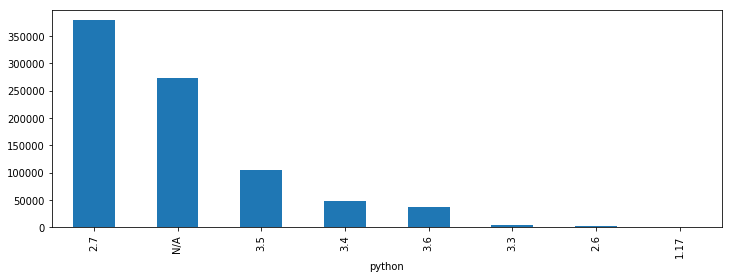

In [5]:
df.groupby('python')['downloads'].sum()\
    .sort_values(ascending=False)[:8].plot.bar(figsize=(12, 4));

In [6]:
df.groupby('python')['downloads'].sum()\
    .sort_values(ascending=False).to_frame()\
    .apply(lambda x: x / x.sum()).style.format('{:.2%}').set_uuid('6')

,downloads
python,
2.7,44.57%
N/A,32.11%
3.5,12.36%
3.4,5.75%
3.6,4.35%
3.3,0.43%
2.6,0.34%
1.17,0.05%
3.7,0.04%


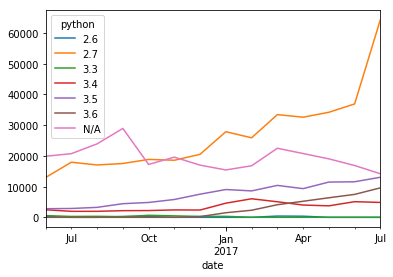

In [7]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 200].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .plot();

In [8]:
gf = df[df['project'] == 'graphviz'].drop('project', axis=1)
gf.head()

,year,month,version,type,country,python,system,downloads
2741,2017,7,0.1,sdist,AU,N/A,N/A,1
2742,2017,7,0.1,sdist,CA,N/A,N/A,1
2743,2017,7,0.1,sdist,CN,N/A,N/A,14
2744,2017,7,0.1,sdist,DE,N/A,N/A,1
2745,2017,7,0.1,sdist,DK,N/A,N/A,1


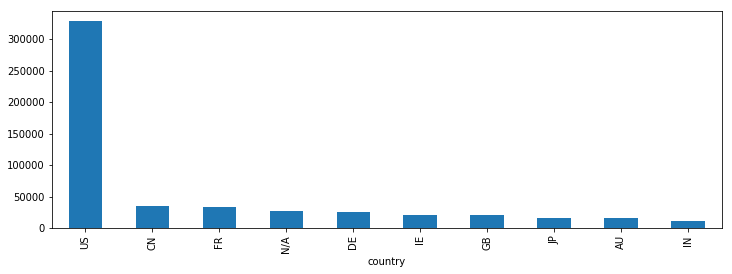

In [9]:
gf.groupby('country')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

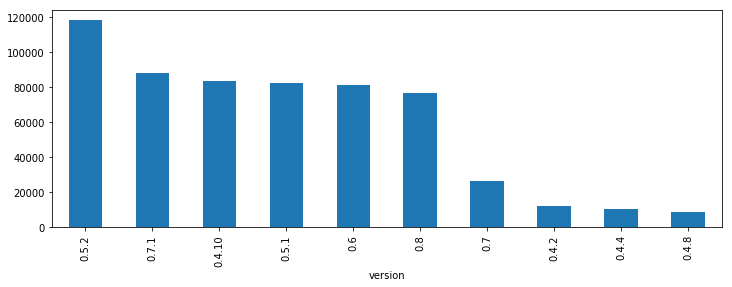

In [10]:
gf.groupby('version')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

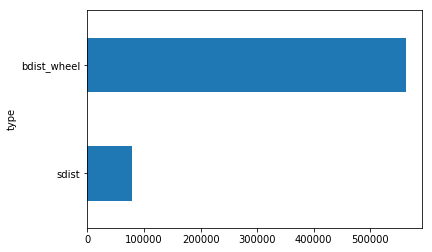

In [11]:
gf.groupby('type')['downloads'].sum().sort_values().plot.barh();

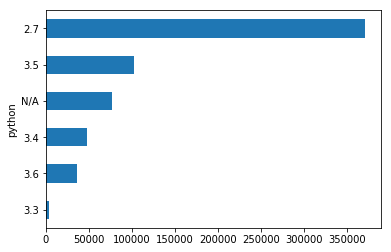

In [12]:
gf.groupby('python')['downloads'].sum().sort_values()[-6:].plot.barh();

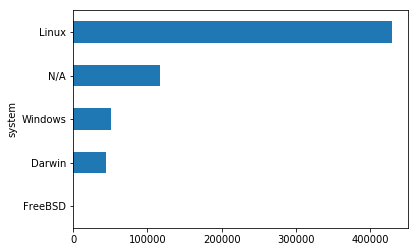

In [13]:
gf.groupby('system')['downloads'].sum().sort_values()[-5:].plot.barh();